## SmartGrid Environment


### SmartGrid Environment 학습 목표

**주제** : SmartGrid Envrionment 이해하기



## 5 substations test case

실제로 학습에 사용될 환경을 자세히 살펴보겠습니다.

In [2]:
import grid2op
from grid2op.PlotGrid import PlotMatplot # Visualization
from tqdm import tqdm, notebook # for easy progress bar
from grid_agent import GridAgent

In [3]:
env = grid2op.make("rte_case5_example", test=True)
plot_helper = PlotMatplot(env.observation_space)

/home/elsa/anaconda3/envs/grid/lib/python3.6/site-packages/grid2op/MakeEnv/Make.py:255: UserWarning:

You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.



[0.6032429  0.73288167 0.5889392  0.48193043 0.60887456 0.3051935
 0.3051935  0.48210987]


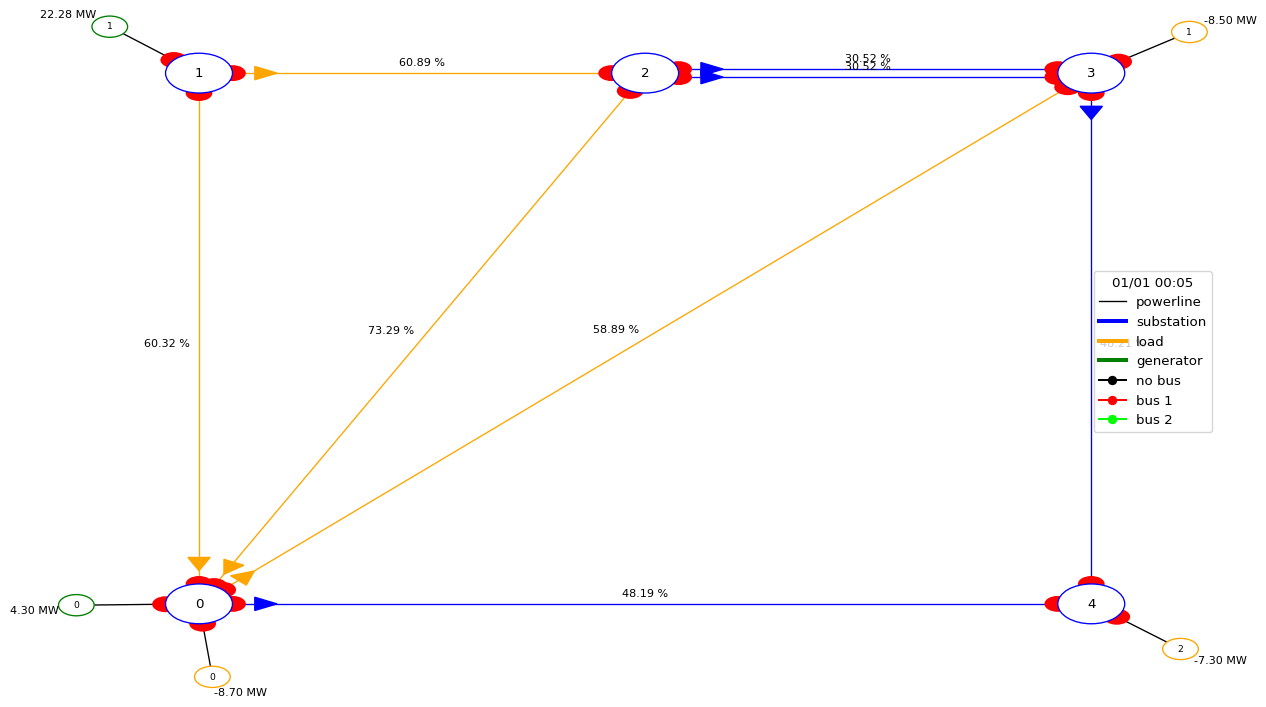

In [23]:
all_obs = []
obs = env.reset()
all_obs.append(obs)
print(obs.rho) # currents flows / thermal limit ratio
_ = plot_helper.plot_obs(obs)

## Create an "do nothing" agent

기본적인 "do nothing" agent를 살펴 보겠습니다. "do nothing" agent는 0번 action만을 수행하며, 환경에 어떠한 영향도 미치지 않는 agent입니다.

In [19]:
from grid2op.Agent import DoNothingAgent
my_agent = DoNothingAgent(env.action_space)

In [26]:
all_obs = []
max_steps = env.chronics_handler.max_timestep()

# test before train
obs, done, nb_step, reward = env.reset(), False, 0, env.reward_range[0]
all_obs.append(obs)
for t in notebook.tqdm(range(max_steps), desc="Smart grid do_nothing agent"):
    action = my_agent.act(obs, reward, done)
    obs, reward, done, _ = env.step(action)
    if done:
        break
    all_obs.append(obs)
    nb_step += 1


print("실제 진행된 timesteps : {}".format(nb_step))
print("가능한 최대 timesteps : {}".format(max_steps))


실제 진행된 timesteps : 524
가능한 최대 timesteps : 2016


  위와 같이 DoNothing Agent, 즉 환경에 어떠한 작용도 하지 않을 경우 최대 step에 도달하지 못하고 game over 되는 상황이 발생합니다.
  Game over 직전 state를 살펴보겠습니다.

[0.8890036  0.         0.         1.3027884  0.33728737 0.32565057
 0.32565057 1.2526829 ]


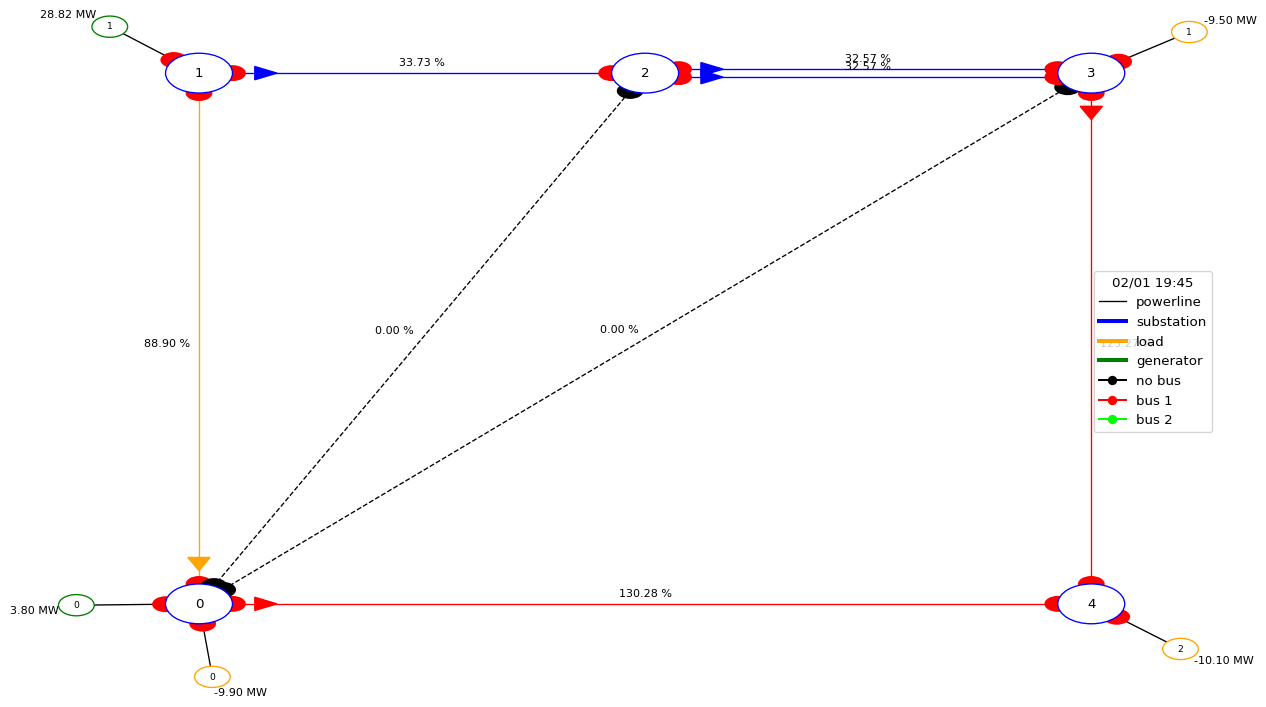

In [27]:
last_obs = all_obs[-1]
print(last_obs.rho)
_ = plot_helper.plot_obs(last_obs)

위 그림과 같이 현재 2개의 powerline(검은 점선)의 연결이 끊어져 있으며, 2개의 powerline(붉은 색)의 연결 또한 끊어지기 직전입니다. 이로 인해 오른쪽 아래의 load를 고립시키고 blackout이 발생, game over가 됩니다.

## SmartGrid state, SmartGrid action

SmartGrid 환경은 gym의 구조와 유사하지만, state(observation)와 action에 차이가 있습니다.
그 부분을 먼저 살펴 보겠습니다.

Cartpole 때와 같은 code를 사용해 한 episode를 test해보겠습니다.

In [30]:
env = grid2op.make("rte_case5_example", test=True,  reward_class=L2RPNReward)
obs = env.reset()

# random한 action을 뽑아 환경에 적용합니다..
action = env.action_space.sample()
print("action : ", action)

obs, reward, done, info = env.step(action)
print("state : {}\nreward : {}\ndone : {}\n\n".format(obs, reward, done))

# 한 episode 에 대한 testing
obs, done, ep_duration = env.reset(), False, 0

while True: 
    action = env.action_space.sample() # action 선택
    obs, reward, done, info = env.step(action)  # 환경에 action 적용
    ep_duration += 1
    if done:  # episode 종료 여부 체크
        break
        
print("episode_duration : ", ep_duration)
env.close()  

/home/elsa/anaconda3/envs/grid/lib/python3.6/site-packages/grid2op/MakeEnv/Make.py:255: UserWarning:

You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.



action :  This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - force reconnection of 1 powerlines ([4])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
state : <grid2op.Space.GridObjects.CompleteObservation_rte_case5_example object at 0x7f0d36147550>
reward : 4.498479843139648
done : False


episode_duration :  1


비교를 위해 CartPole 환경의 action과 state를 다시 살펴보겠습니다.

In [31]:
import gym
env = gym.make("CartPole-v0")

obs = env.reset()

# random한 action을 뽑아 환경에 적용합니다..
action = env.action_space.sample()
print("action : ", action)

obs, reward, done, info = env.step(action)
print("state : {}\nreward : {}\ndone : {}\n\n".format(obs, reward, done))

# 한 episode 에 대한 testing
obs, done, ep_duration = env.reset(), False, 0

while True: 
    action = env.action_space.sample() # action 선택
    obs, reward, done, info = env.step(action)  # 환경에 action 적용
    ep_duration += 1
    if done:  # episode 종료 여부 체크
        break
        
env.close()  

action :  0
state : [-0.02502357 -0.16055303 -0.03921686  0.23826141]
reward : 1.0
done : False




위와 같이 action과 state의 형태가 이전의 형태와 다르다는 사실을 알 수 있습니다.